In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import glob
import imageio
import zipfile
import tqdm
import natsort

from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Input
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization
from keras.layers import Activation

from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Accuracy
from keras.preprocessing import image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = '/content/drive/MyDrive/Data/Data'

In [4]:
os.listdir('/content/drive/MyDrive/Data')

['Data', 'Ground truth']

In [5]:
file_path = '/content/drive/MyDrive/Data'

In [56]:
def clahe(img, clip_limit=2.0, grid_size=(8, 8)):
    clahe_obj = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)

    # Handle color images
    if len(img.shape) == 3:
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        lab[:, :, 0] = clahe_obj.apply(lab[:, :, 0])
        return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    else:
        # Grayscale image
        return img_new.apply(img)

In [13]:
import os, cv2

images = []
files = sorted(os.listdir(file_path+ "/Data"))
img_new = []
gt_x = len(files)
for i in range(gt_x):
  img = cv2.imread(file_path+ "/Data"+'/'+files[i])
  img = cv2.resize(img, (256, 256))
  images.append(img)
  img_clahe = clahe(img)
  img_new.append(img_clahe)

In [14]:
import os, cv2
from pathlib import Path

truth_images = []
files = sorted(os.listdir(file_path+ "/Ground truth"))

gt_x = len(files)
for i in range(gt_x):
      img = cv2.imread(file_path+ "/Ground truth"+'/'+files[i])
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      img = cv2.resize(img, (256, 256))
      truth_images.append(img)

In [57]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Layer

class SelfAttention2D(Layer):
    def __init__(self, filters, **kwargs):
        super(SelfAttention2D, self).__init__(**kwargs)
        self.filters = filters
        self.query_conv = keras.layers.Conv2D(filters // 8, (1, 1), padding="same", name='query')
        self.key_conv = keras.layers.Conv2D(filters // 8, (1, 1), padding="same", name='key')
        self.value_conv = keras.layers.Conv2D(filters, (1, 1), padding="same", name='value')

    def build(self, input_shape):
        self.gamma = self.add_weight(
            name='gamma',
            shape=(1,),
            initializer='zeros',
            trainable=True
        )
        super(SelfAttention2D, self).build(input_shape)

    def call(self, x):
        batch_size = tf.shape(x)[0]
        height = tf.shape(x)[1]
        width = tf.shape(x)[2]

        query = self.query_conv(x)
        key = self.key_conv(x)
        value = self.value_conv(x)

        # Reshape for attention computation
        query = tf.reshape(query, [batch_size, -1, self.filters // 8])
        key = tf.reshape(key, [batch_size, -1, self.filters // 8])
        value = tf.reshape(value, [batch_size, -1, self.filters])

        # Compute attention
        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_scores = attention_scores / tf.sqrt(tf.cast(self.filters // 8, tf.float32))
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)

        # Apply attention to values
        attended = tf.matmul(attention_weights, value)
        attended = tf.reshape(attended, [batch_size, height, width, self.filters])

        # Residual connection with learnable weight
        output = self.gamma * attended + x

        return output

    def get_config(self):
        config = super(SelfAttention2D, self).get_config()
        config.update({'filters': self.filters})
        return config

def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1, use_attention=False):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)

    if use_attention:
        c = SelfAttention2D(filters)(c)

    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def UNet2D(use_attention=True):
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((256, 256, 3))

    p0 = inputs
    c1, p1 = down_block(p0, f[0], use_attention=False)
    c2, p2 = down_block(p1, f[1], use_attention=False)
    c3, p3 = down_block(p2, f[2], use_attention=use_attention)
    c4, p4 = down_block(p3, f[3], use_attention=use_attention)

    bn = bottleneck(p4, f[4])

    u1 = up_block(bn, c4, f[3])
    u2 = up_block(u1, c3, f[2])
    u3 = up_block(u2, c2, f[1])
    u4 = up_block(u3, c1, f[0])

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [43]:
import tensorflow as tf
from tensorflow import keras

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Dice coefficient for evaluation (higher is better)
    """
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Dice loss for training (lower is better)
    """
    return 1 - dice_coefficient(y_true, y_pred, smooth)

def bce_dice_loss(y_true, y_pred):
    """
    Combined Binary Cross-Entropy and Dice Loss
    """
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    bce = tf.reduce_mean(bce)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

def iou_score(y_true, y_pred, smooth=1e-6):
    """
    IoU score (Jaccard index) for evaluation
    """
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [44]:
def preprocess(x, y):
  x = tf.expand_dims(x, axis=-1)
  y = float(y)/255.0
  return x, y

In [45]:
from sklearn.model_selection import train_test_split

img_train, img_valtest, t_img_train, t_img_valtest = train_test_split(img_new, truth_images, train_size = 0.6, test_size = 0.4)
img_val, img_test, t_img_val, t_img_test = train_test_split(img_valtest, t_img_valtest, train_size = 0.5, test_size = 0.5)

train_dataset = tf.data.Dataset.from_tensor_slices((img_train, t_img_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((img_val, t_img_val))
test_dataset = tf.data.Dataset.from_tensor_slices((img_test, t_img_test))

train_datagen = (train_dataset.shuffle(len(img_train)).map(preprocess).batch(8))
validation_datagen = (validation_dataset.shuffle(len(img_val)).map(preprocess).batch(8))
test_datagen = (test_dataset.shuffle(len(img_test)).map(preprocess).batch(1))

In [46]:
model = UNet2D(use_attention=True)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 256, 256,  │        448 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 256, 256,  │      2,320 │ conv2d_75[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 128, 128,  │          0 │ conv2d_76[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_12… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_77[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 64, 64,    │          0 │ conv2d_78[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_13… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_79[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ self_attention2d_6  │ (None, 64, 64,    │      5,201 │ conv2d_80[0][0]   │
│ (SelfAttention2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 32, 32,    │          0 │ self_attention2d… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_14… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_82 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_81[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ self_attention2d_7  │ (None, 32, 32,    │     20,641 │ conv2d_82[0][0]   │
│ (SelfAttention2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 16, 16,    │          0 │ self_attention2d… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_83 (Conv2D)  │ (None, 16, 16,    │    295,168 │ max_pooling2d_15… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_84 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_83[0][0] 

 Total params: 1,988,467 (7.59 MB)

 Trainable params: 1,988,467 (7.59 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard

In [48]:
callbacks = [
    TensorBoard(),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
]

In [49]:
model.compile(
  loss=bce_dice_loss,
  optimizer=tf.keras.optimizers.Adam(learning_rate= 0.0001),
  metrics=[tf.metrics.BinaryAccuracy(), dice_coefficient, tf.metrics.Recall(), tf.metrics.Precision(), iou_score],
)

In [50]:
history = model.fit(train_datagen,
  validation_data = validation_datagen,
  verbose = 1,
  epochs = 100,
  callbacks=callbacks
                    )

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - binary_accuracy: 0.8836 - dice_coefficient: 0.1428 - iou_score: 0.0777 - loss: 1.4017 - precision_4: 0.1625 - recall_4: 0.1489 - val_binary_accuracy: 0.9289 - val_dice_coefficient: 0.1697 - val_iou_score: 0.0955 - val_loss: 1.2237 - val_precision_4: 0.6072 - val_recall_4: 0.1230
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - binary_accuracy: 0.9224 - dice_coefficient: 0.2466 - iou_score: 0.1446 - loss: 1.0766 - precision_4: 0.3677 - recall_4: 0.2894 - val_binary_accuracy: 0.9326 - val_dice_coefficient: 0.3171 - val_iou_score: 0.1927 - val_loss: 0.9562 - val_precision_4: 0.6079 - val_recall_4: 0.2660
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - binary_accuracy: 0.9164 - dice_coefficient: 0.3168 - iou_score: 0.1940 - loss: 0.9638 - precision_4: 0.4099 - recall_4: 0.3573 - val_binary_accuracy: 0.9035 - val_dice_coefficient: 0.4074 - val_iou_score: 0.2647 - val_loss: 0.8589 - val_precision_4: 0.4029 - val_recall_4: 0.60

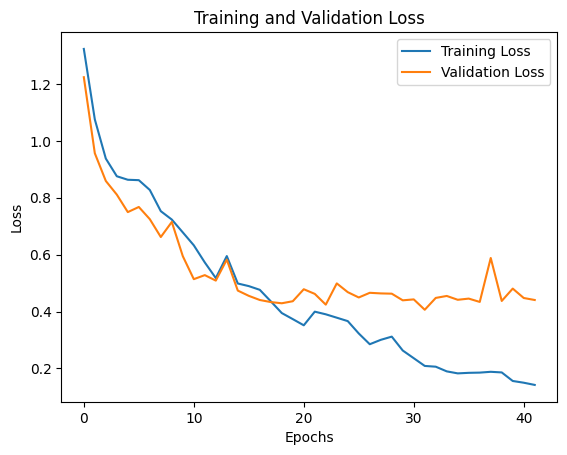

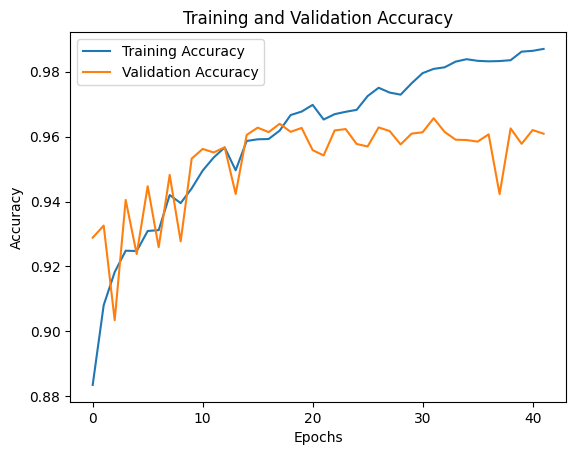

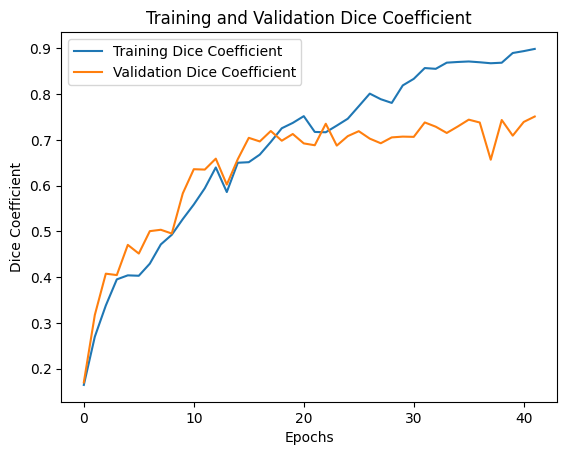

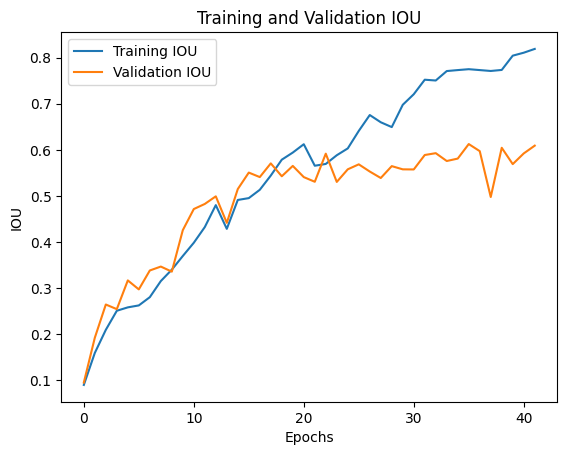

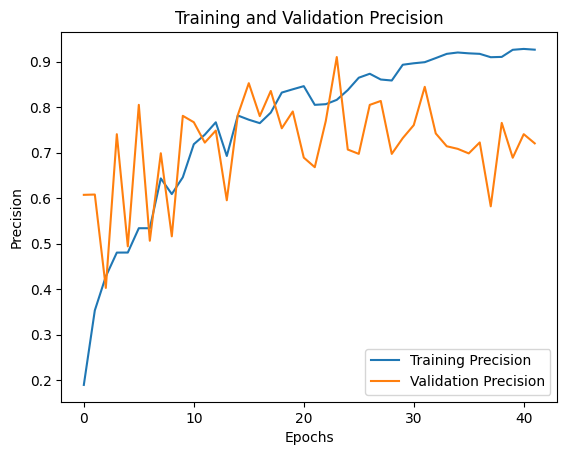

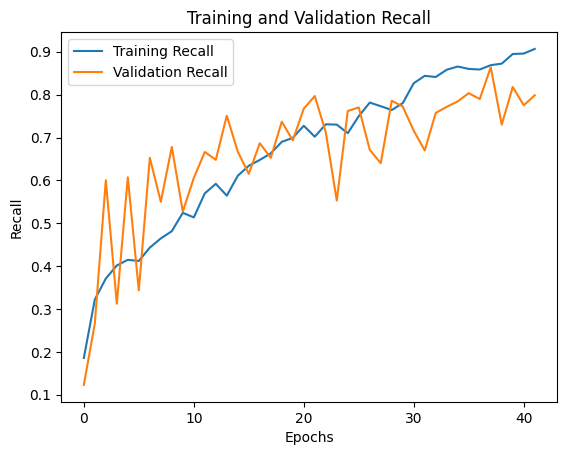

In [54]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot training and validation accuracy
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plot training and validation dice coefficient
plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.title('Training and Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

plt.plot(history.history['iou_score'], label='Training IOU')
plt.plot(history.history['val_iou_score'], label='Validation IOU')
plt.title('Training and Validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

plt.plot(history.history['precision_4'], label='Training Precision')
plt.plot(history.history['val_precision_4'], label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

plt.plot(history.history['recall_4'], label='Training Recall')
plt.plot(history.history['val_recall_4'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [55]:
x = model.evaluate(test_datagen)

88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - binary_accuracy: 0.9651 - dice_coefficient: 0.7088 - iou_score: 0.6099 - loss: 0.4883 - precision_4: 0.7385 - recall_4: 0.7468
